# <span style='color:orange'>Forest Fire Prediction</span>

### In this project I'm trying to predict the confidence for a forest fire to take place.

In [1]:
# import dependencies 
import os
import datetime as dt
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [2]:
# set the working directory
new_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
os.chdir(new_dir)    


In [8]:
# loading the dataset
forestFireSet = pd.read_parquet('data/fire_archive.parquet')

## let's have a look on the dataset

In [4]:
# check the head of the data
forestFireSet.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,-11.8070,142.0583,313.0,1.0,1.0,2019-08-01,56,Terra,MODIS,48,6.3,297.3,6.6,D,0
1,-11.7924,142.0850,319.3,1.0,1.0,2019-08-01,56,Terra,MODIS,71,6.3,297.3,11.3,D,0
2,-12.8398,132.8744,311.6,3.1,1.7,2019-08-01,57,Terra,MODIS,42,6.3,298.7,23.1,D,0
3,-14.4306,143.3035,310.1,1.1,1.1,2019-08-01,57,Terra,MODIS,33,6.3,296.1,6.5,D,0
4,-12.4953,131.4897,310.3,4.0,1.9,2019-08-01,57,Terra,MODIS,36,6.3,298.8,27.6,D,0


In [5]:
# check the datashape
print(forestFireSet.shape)

# check the schema 
print(forestFireSet.dtypes)

(36011, 15)
latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite      object
instrument     object
confidence      int64
version       float64
bright_t31    float64
frp           float64
daynight       object
type            int64
dtype: object


<p><span style="color:cyan">The data set includes 15 fields and ~36K rows. 
Some of the fields are text objects. </span></p>

Let's review the status of missing values

In [6]:
# check for missing values
forestFireSet.isnull().sum()

latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64

<p><span style="color:cyan">There are no missing values to handle </span></p>

Let's describe the set, to get a better sense of its numerical values distribution and other fields behavior

In [7]:
forestFireSet.describe(include='all')

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
count,36011.000000,36011.000000,36011.000000,36011.000000,36011.000000,36011,36011.000000,36011,36011,36011.000000,3.601100e+04,36011.000000,36011.000000,36011,36011.000000
unique,NaN,NaN,NaN,NaN,NaN,61,NaN,2,1,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,2019-09-10,NaN,Aqua,MODIS,NaN,NaN,NaN,NaN,D,NaN
freq,NaN,NaN,NaN,NaN,NaN,1317,NaN,20541,36011,NaN,NaN,NaN,NaN,28203,NaN
mean,-19.100962,138.931446,328.750696,1.620905,1.215281,NaN,600.025798,NaN,NaN,67.551387,6.300000e+00,301.339138,51.132176,NaN,0.019439
std,7.265777,9.261400,18.992808,0.813764,0.247852,NaN,548.369111,NaN,NaN,23.179946,1.776382e-15,9.724462,92.280112,NaN,0.198326
min,-42.762800,114.104300,300.000000,1.000000,1.000000,NaN,0.000000,NaN,NaN,0.000000,6.300000e+00,267.000000,0.000000,NaN,0.000000
25%,-26.370250,131.072250,316.500000,1.100000,1.000000,NaN,205.000000,NaN,NaN,52.000000,6.300000e+00,293.600000,13.800000,NaN,0.000000
50%,-15.706500,136.738500,326.400000,1.300000,1.100000,NaN,424.000000,NaN,NaN,70.000000,6.300000e+00,302.400000,25.800000,NaN,0.000000
75%,-13.343600,147.477500,336.700000,1.900000,1.300000,NaN,600.000000,NaN,NaN,86.000000,6.300000e+00,308.600000,52.800000,NaN,0.000000


In [8]:
forestFireSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36011 entries, 0 to 36010
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    36011 non-null  float64
 1   longitude   36011 non-null  float64
 2   brightness  36011 non-null  float64
 3   scan        36011 non-null  float64
 4   track       36011 non-null  float64
 5   acq_date    36011 non-null  object 
 6   acq_time    36011 non-null  int64  
 7   satellite   36011 non-null  object 
 8   instrument  36011 non-null  object 
 9   confidence  36011 non-null  int64  
 10  version     36011 non-null  float64
 11  bright_t31  36011 non-null  float64
 12  frp         36011 non-null  float64
 13  daynight    36011 non-null  object 
 14  type        36011 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 4.1+ MB


<AxesSubplot:>

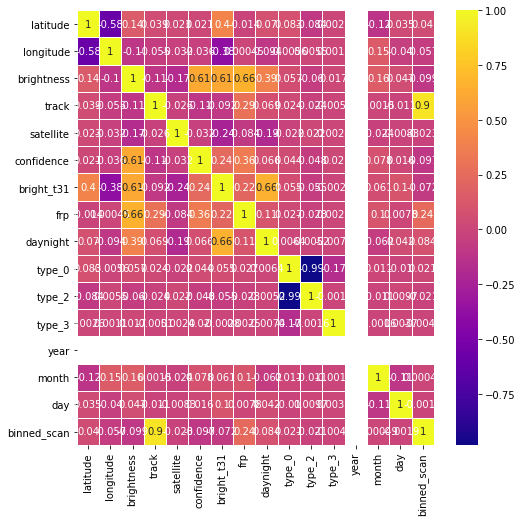

In [26]:
plt.figure(figsize=(8, 8))
sns.heatmap(forestFireSet.corr(),annot=True,cmap='plasma',linewidths=.5)


In [10]:
# lets check the values count for each categorical field
df2 = forestFireSet.select_dtypes(include=['object'])
df2.drop(columns="acq_date",inplace=True) #excluding the date column
df2.apply(pd.Series.value_counts)

C:\Users\cohenniv\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,satellite,instrument,daynight
Aqua,20541.0,NaN,NaN
D,NaN,NaN,28203.0
MODIS,NaN,36011.0,NaN
N,NaN,NaN,7808.0
Terra,15470.0,NaN,NaN


### <span style="color:cyan"> We can see that the categorical features satelite and daynight, have only 2 unique values.<br>Therefore, we can be easly encoded to boolean type. while the Instrument seems to have only a single value and it's not adding any information so we can drop it.<br><br> Earlier from the describe print we were able to tell the version field include only a single possible value (min and max values are the same) </span>

In [11]:
# drop non-relevant fields
forestFireSet.drop(columns=['instrument','version'], inplace=True)

In [12]:
# encode the satelite and daynight columns and convert them into integers
daynightMap = {"D": 1, "N": 0}
satelliteMap = {"Terra": 1, "Aqua": 0}

forestFireSet['daynight'] = forestFireSet['daynight'].map(daynightMap).astype(int)
forestFireSet['satellite'] = forestFireSet['satellite'].map(satelliteMap).astype(int)


### although the type field seems to be numerical it is actually categorical.

In [13]:
forestFireSet.type.unique()

array([0, 2, 3], dtype=int64)

<span style = "color:cyan">Since the type category includes multimple categories we can either keep it as integer or try to one-hot encode it</span>

In [14]:
# one hot encoding the type field
forestFireSet = pd.get_dummies(forestFireSet, prefix=["type"], columns=["type"], drop_first=False)
forestFireSet.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,bright_t31,frp,daynight,type_0,type_2,type_3
0,-11.8070,142.0583,313.0,1.0,1.0,2019-08-01,56,1,48,297.3,6.6,1,1,0,0
1,-11.7924,142.0850,319.3,1.0,1.0,2019-08-01,56,1,71,297.3,11.3,1,1,0,0
2,-12.8398,132.8744,311.6,3.1,1.7,2019-08-01,57,1,42,298.7,23.1,1,1,0,0
3,-14.4306,143.3035,310.1,1.1,1.1,2019-08-01,57,1,33,296.1,6.5,1,1,0,0
4,-12.4953,131.4897,310.3,4.0,1.9,2019-08-01,57,1,36,298.8,27.6,1,1,0,0


In [17]:
# converting the acq_date into date type
forestFireSet['acq_date'] = pd.to_datetime(forestFireSet['acq_date'])

# adding year, month and day fields
forestFireSet['year'] = forestFireSet['acq_date'].dt.year
forestFireSet['month'] = forestFireSet['acq_date'].dt.month
forestFireSet['day'] = forestFireSet['acq_date'].dt.day

### Earlier we saw in the heatmap, that scan and track are both very centric features.<br>Continuous features have a smaller chance of correlating with the target variable due to infinite degrees of freedom and may have a complex non-linear relationship.<br> Thus, it may be harder to interpret an such a function. After discretizing a variable, the group corresponding to the target can be interpreted.<br><br> There are many ways to discretize, unsupervised approaches such as equal frequency or kmeans. <br> Lets go with Equal-Width Discretization



In [18]:
from sklearn.preprocessing import KBinsDiscretizer
# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=5, encode='ordinal')
X_binned = enc.fit_transform(forestFireSet[["scan"]])
forestFireSet["binned_scan"] = X_binned 

forestFireSet.head(n=20)


C:\Users\cohenniv\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,bright_t31,frp,daynight,type_0,type_2,type_3,year,month,day,binned_scan
0,-11.8070,142.0583,313.0,1.0,1.0,2019-08-01,56,1,48,297.3,6.6,1,1,0,0,2019,8,1,0.0
1,-11.7924,142.0850,319.3,1.0,1.0,2019-08-01,56,1,71,297.3,11.3,1,1,0,0,2019,8,1,0.0
2,-12.8398,132.8744,311.6,3.1,1.7,2019-08-01,57,1,42,298.7,23.1,1,1,0,0,2019,8,1,3.0
3,-14.4306,143.3035,310.1,1.1,1.1,2019-08-01,57,1,33,296.1,6.5,1,1,0,0,2019,8,1,0.0
4,-12.4953,131.4897,310.3,4.0,1.9,2019-08-01,57,1,36,298.8,27.6,1,1,0,0,2019,8,1,3.0
5,-12.6191,142.1998,314.8,1.0,1.0,2019-08-01,57,1,68,297.6,9.3,1,1,0,0,2019,8,1,0.0
6,-14.3655,143.5682,305.4,1.2,1.1,2019-08-01,57,1,24,283.9,5.9,1,1,0,0,2019,8,1,1.0
7,-14.3195,143.5198,322.9,1.2,1.1,2019-08-01,57,1,79,290.9,20.4,1,1,0,0,2019,8,1,1.0
8,-13.1654,141.9715,317.2,1.0,1.0,2019-08-01,57,1,72,300.0,9.9,1,1,0,0,2019,8,1,0.0
9,-11.5473,132.6796,311.5,3.4,1.7,2019-08-01,57,1,40,298.7,27.3,1,1,0,0,2019,8,1,3.0


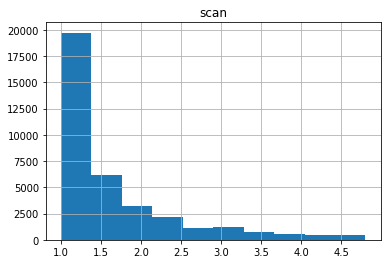

In [19]:
forestFireSet[["scan"]].hist()
plt.show()

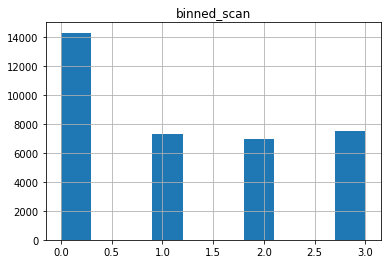

In [20]:
forestFireSet[["binned_scan"]].hist()
plt.show()

In [21]:
print(forestFireSet.groupby("binned_scan").agg({"scan":["mean","min","max"]}))

                 scan          
                 mean  min  max
binned_scan                    
0.0          1.042005  1.0  1.1
1.0          1.283890  1.2  1.4
2.0          1.702667  1.5  2.0
3.0          2.973365  2.1  4.8


### <span style = "color:cyan"> As it can be seen from the 2nd histogram I discritized evenly. I'm not sure this is the correct approach here.</span>

Another approach we can try is:

In [22]:
bins = [0, 1, 2, 3, 4, 5]
labels = [1,2,3,4,5]
forestFireSet['binned_scan2'] = pd.cut(forestFireSet['scan'], bins=bins, labels=labels)

print(forestFireSet.groupby("binned_scan2").agg({"scan":["mean","min","max"]}))

                  scan          
                  mean  min  max
binned_scan2                    
1             1.000000  1.0  1.0
2             1.373004  1.1  2.0
3             2.489067  2.1  3.0
4             3.490022  3.1  4.0
5             4.439869  4.1  4.8


### It's hard to tell which one will work better. we'll give them both a try, meanwhile lets drop the original column

In [25]:
# drop the original scan, acq_date, acq_time columns
forestFireSet.drop(columns=['scan','acq_date', 'acq_time'], inplace=True)

In [28]:
forestFireSet.head()

,latitude,longitude,brightness,track,satellite,confidence,bright_t31,frp,daynight,type_0,type_2,type_3,year,month,day,binned_scan,binned_scan2
0,-11.8070,142.0583,313.0,1.0,1,48,297.3,6.6,1,1,0,0,2019,8,1,0.0,1
1,-11.7924,142.0850,319.3,1.0,1,71,297.3,11.3,1,1,0,0,2019,8,1,0.0,1
2,-12.8398,132.8744,311.6,1.7,1,42,298.7,23.1,1,1,0,0,2019,8,1,3.0,4
3,-14.4306,143.3035,310.1,1.1,1,33,296.1,6.5,1,1,0,0,2019,8,1,0.0,2
4,-12.4953,131.4897,310.3,1.9,1,36,298.8,27.6,1,1,0,0,2019,8,1,3.0,4


### checking again the behavior correlation heatmap

<AxesSubplot:>

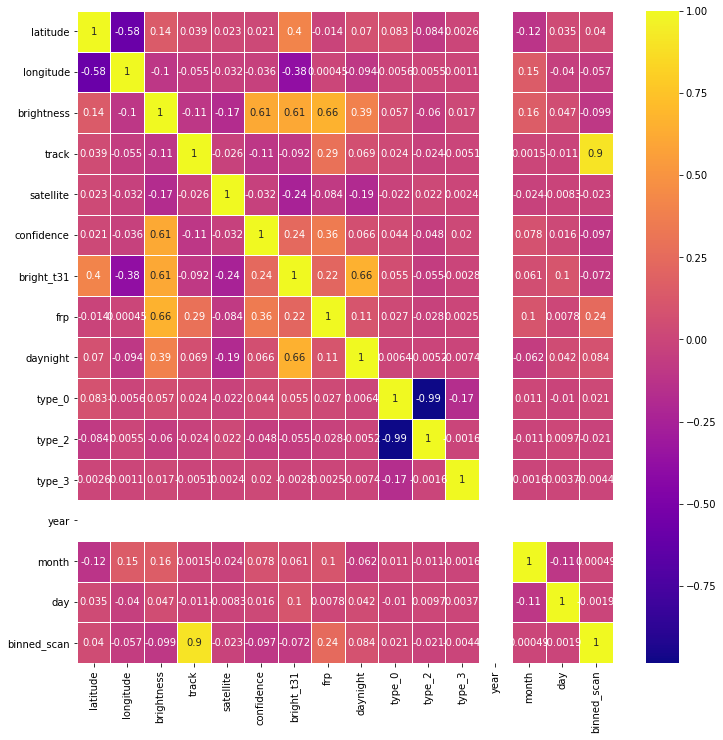

In [27]:
plt.figure(figsize=(12, 12))
sns.heatmap(forestFireSet.corr(),annot=True,cmap='plasma',linewidths=.5)

### <span style="color:cyan">It's now looks much more cleaner and we can see a clear correlation add with the new <br> features I just added.<br>Althougt, the year column includes in this set only a single value of 2019 I'll keep it for future use</span>

# Modeling

### split into train and test (80:20 ratio) 

In [34]:
forestFireSet.columns

Index(['latitude', 'longitude', 'brightness', 'track', 'satellite',
       'confidence', 'bright_t31', 'frp', 'daynight', 'type_0', 'type_2',
       'type_3', 'year', 'month', 'day', 'binned_scan', 'binned_scan2'],
      dtype='object')

In [44]:
# selected features
features = [
    'latitude', 'longitude', 'brightness', 'track', 'satellite',
    'bright_t31', 'frp', 'daynight', 'type_0', 'type_2','type_3', 'year', 
    'month', 'day', 'binned_scan'
    ]

# seperate the target feature
target =  forestFireSet["confidence"]
final = forestFireSet.loc[:,features]
# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(final,target, test_size=0.2)


### We'll try to model this problem using Random Forest regressor. <br> Random forests are popularly applied to both data science competitions and practical problems. They are often accurate, do not require feature scaling, <br> categorical feature encoding, and need little parameter tunning. They can also be more interpretable than other complex models such as neural networks.<br><br> I'll be trying regressor since I'm looking for confidance level and not a classification. 

In [45]:
rf_model = RandomForestRegressor(n_estimators=300, random_state = 42, n_jobs = -1)
#Fit
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

#Checking the accuracy of the trained model on the training data
random_model_accuracy = round(rf_model.score(x_train, y_train)*100,2)
print(round(random_model_accuracy, 2), '%')

# checking the accuract of the test set
random_model_accuracy1 = round(rf_model.score(x_test, y_test)*100,2)
print(round(random_model_accuracy1, 2), '%')

95.38 %
66.47 %


Text(0.5, 0, 'Permutation Importance')

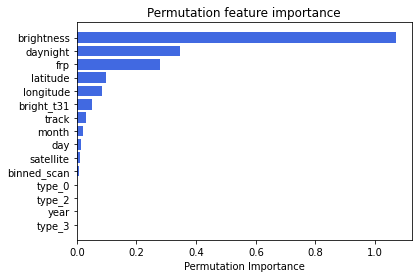

In [51]:
# Permutation feature importance
perm_importance = permutation_importance(rf_model, x_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(final.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color = 'royalblue')
plt.title("Permutation feature importance")
plt.xlabel("Permutation Importance")

### <span style="color:cyan">So far we tried a baseline model, helping us to understand we are not overfitting and although accurecy is great, <br> we still have something to work with.<br> now lets start tune the model</span>

## Lets build a grid search...

In [53]:
def randm_cv(rf_model,n_iter=50, cv=3):
    """
    This method will execute RadomizedSearchCV.
    A random search of parameters, using fold cross-validation, search across 100 different combinations and use all available cores

    Args:
        rf_model: sickit-learn random forest model
        (n_iter, int, optional):  controls the number of different combinations to try. Default value is 50
        (cv, int, optional): which is the number of folds to use for cross-validation. Default value is 3

    Returns:
        model - a new optimized model object 
        
    n_estimators = number of trees in the forest
    max_features = max number of features considered for splitting a node
    max_depth = max number of levels in each decision tree
    min_samples_split = min number of data points placed in a node before the node is split
    min_samples_leaf = min number of data points allowed in a leaf node
    bootstrap = method for sampling data points (with or without replacement)
    """
    from sklearn.model_selection import RandomizedSearchCV

    #Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 20)]
    #Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    #Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(15, 35, num = 7)]
    max_depth.append(None)
    #Minimum number of samples required to split a node
    min_samples_split = [2, 3, 5]
    #Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    #Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                    }
    
    model = RandomizedSearchCV(
        estimator = rf_model, 
        param_distributions = random_grid, 
        n_iter = 50, 
        cv = 3, 
        verbose=2, 
        random_state=42)

    return(model)


In [54]:
# run a grid search
new_rf_model = randm_cv(rf_model = rf_model, n_iter=50, cv=3)
# Fit the random search model
new_rf_model.fit(x_train, y_train)

print(new_rf_model.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=18, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=415; total time=   8.7s
[CV] END max_depth=18, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=415; total time=   4.4s
[CV] END max_depth=18, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=415; total time=   4.5s
[CV] END max_depth=28, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=436; total time=   5.9s
[CV] END max_depth=28, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=436; total time=   5.9s
[CV] END max_depth=28, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=436; total time=   5.7s
[CV] END max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=478; total time=   3.0s
[CV] END max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=47

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                                   random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [15, 18, 21, 25, 28, 31,
                                                      35, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [300, 310, 321, 331,
                                                         342, 352, 363, 373,
                                                         384, 394, 405, 415,
                                                         426, 436, 447, 457,
                                                         468, 478, 489, 500]},
                   random_state=42, verbose=2)

In [55]:
print(new_rf_model.best_params_)

{'n_estimators': 394, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}


In [56]:
# retrain the model with the best parameters
random_new = RandomForestRegressor(
    n_estimators = 394, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    max_features = 'sqrt',
    max_depth = 25, 
    bootstrap = True)

#Fit
random_new.fit(x_train, y_train)

#Checking the accuracy on train set
random_model_accuracy1 = round(random_new.score(x_train, y_train)*100,2)
print(round(random_model_accuracy1, 2), '%')

#Checking the accuracy on test set
random_model_accuracy2 = round(random_new.score(x_test, y_test)*100,2)
print(round(random_model_accuracy2, 2), '%')

95.48 %
68.15 %


In [62]:
# saving the model into a pickle file
saved_model = pickle.dump(random_new, open('ForestModel.pickle','wb'))